In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from utils import *
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [53]:
# 原始图
ori_f = h5py.File("./diff_pre_images/recv_unknown_no_train_ori.h5")
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
ori_imgs = np.array([np.array(ori_f[i]).squeeze(0).transpose(1,2,0) for i in names]).squeeze(-1)
print(ori_imgs.shape)

(7, 128, 128)


In [4]:
f1 = h5py.File("./recvs/res/float64_GPSR_res.h5")
f2 = h5py.File("./recvs/res/float64_OMP_res.h5")

In [54]:
GPSR_res = np.array(f1["value"]).reshape((3,7,128,128))
OMP_res = np.array(f2["value"])
print(GPSR_res.shape,OMP_res.shape)

(3, 7, 128, 128) (3, 7, 128, 128)


In [11]:
def parse_f_no_train(f):
    return [np.array(f["Img_{}".format(i)]).squeeze(0).transpose(1,2,0) for i in range(6)]
epochs=[20,30,50]

In [19]:
ff = h5py.File("./diff_pre_images/recv_unknown_no_train_in_0.h5")
GLs = [np.array(ff["GI{}".format("" if i==20 else "_" + str(i))]).squeeze(0).transpose(1,2,0) for i in epochs]  
Img_recvs_no_train_two_loop_in_0 = np.array([GLs[1]] + parse_f_no_train(ff))

In [20]:
ff2 = h5py.File("./diff_pre_images/recv_unknown_no_train_s_0.5.h5")
GLs2 = [np.array(ff2["GI{}".format("" if i==20 else "_" + str(i))]).squeeze(0).transpose(1,2,0) for i in [30]]  
Img_recvs_no_train_two_loop_s_5 = np.array([GLs2[0]] + parse_f_no_train(ff2))

In [21]:
ff3 = h5py.File("./diff_pre_images/recv_unknown_no_train_gi.h5")  
Img_recvs_no_train_two_loop_gi = np.array([np.array(ff3["GI"]).squeeze(0).transpose(1,2,0)] + parse_f_no_train(ff3))

In [55]:
Diffusion_res = np.array([Img_recvs_no_train_two_loop_gi, Img_recvs_no_train_two_loop_in_0, Img_recvs_no_train_two_loop_s_5])
Diffusion_res.shape

(3, 7, 128, 128, 3)

In [67]:
# (3,3,7,8)
eval_res = np.empty((3,3,7,8))
for i in range(3):
    PM_res = [
        GPSR_res[i],
        OMP_res[i],
        Diffusion_res[i]
    ]
    for j in range(3):
        res = PM_res[j]
        for k in range(7):
            ori_img = ori_imgs[k]
            gen_img = res[k]
            if len(gen_img.shape)>2 and gen_img.shape[2]>1:
                gen_img = cv2.cvtColor(gen_img,cv2.COLOR_BGR2GRAY)
            c_res = compareRes(ori_img, gen_img, multichannel=False,channel_axis=None)
            mse = c_res["mse"]
            psnr = c_res["psnr"]
            ssim = c_res["ssim"]
            pncc = c_res["pncc"][0]
            emes_pairs = c_res["emes"]
            eprs_pairs = c_res["eprs"]
            emes = emes_pairs[1] / emes_pairs[0]
            eprs = eprs_pairs[1] / eprs_pairs[0]
            cc_res = [mse,psnr,ssim,pncc,emes,eprs,emes_pairs[1],eprs_pairs[1]]
            eval_res[i,j,k,:]=cc_res

In [77]:
# 有a/b/c三种类型的数据，n设置为3
total_width, n = 0.8, 3
# 每种类型的柱状图宽度
width = total_width / n
x = np.arange(7)
# 重新设置x轴的坐标
# x = x - (total_width - width) / 2

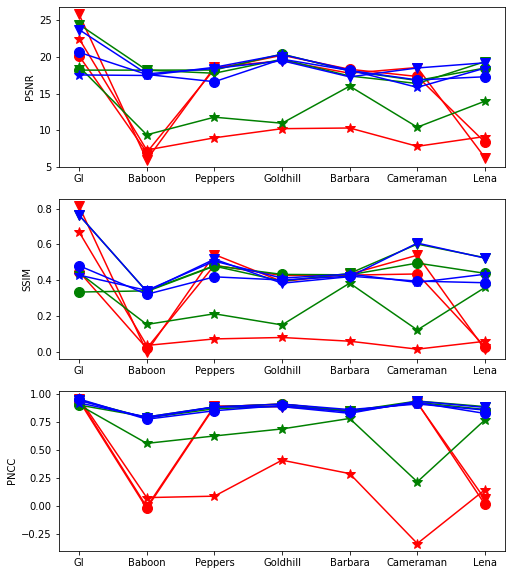

In [100]:
plt.figure(figsize=(8,10))

s_idxs=[1,2,3]
y_labels=["PSNR", "SSIM", "PNCC"]
colors = ["r","g","b"]  # PM
marks = ["*","o","v"]   # Method
for i in range(3):
    c = colors[i]
    for j in range(3):
        m = marks[j]
        evals = eval_res[i,j]
        for k in range(3):
            plt.subplot(3,1,k+1)
            plt.plot(x, evals[:,s_idxs[k]],color=c,marker=m,markersize=10)
            plt.xticks(x, names)
            plt.ylabel(y_labels[k])
plt.savefig("./res.jpg")

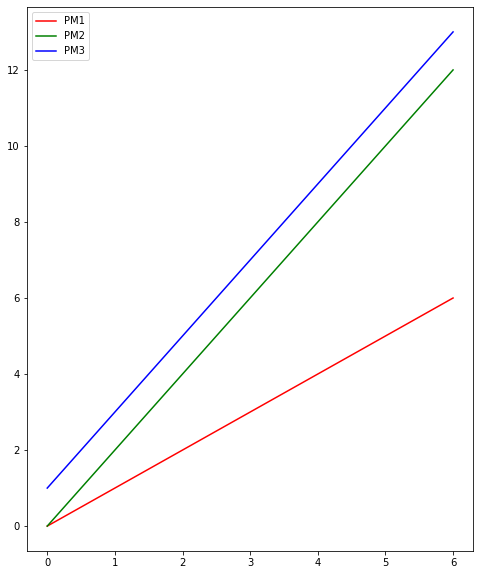

In [101]:
plt.figure(figsize=(8,10))
plt.plot(x, x, color=colors[0],label="PM1")
plt.plot(x, 2*x, color=colors[1],label="PM2")
plt.plot(x, 2*x+1, color=colors[2],label="PM3")
plt.legend()
plt.savefig("./res-1.jpg")

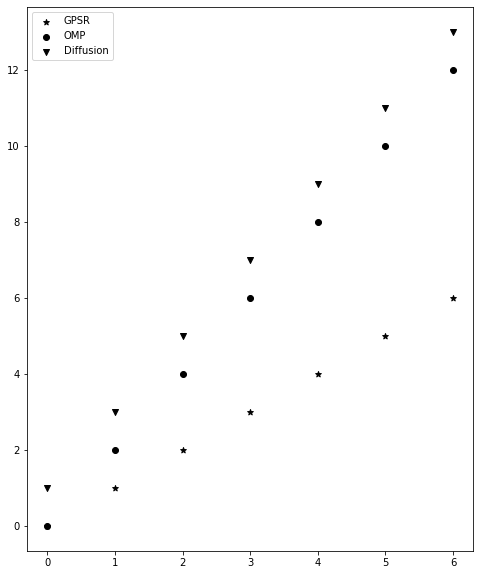

In [102]:
plt.figure(figsize=(8,10))
plt.scatter(x, x, c="black", marker=marks[0],label="GPSR")
plt.scatter(x, 2*x, c="black",marker=marks[1],label="OMP")
plt.scatter(x, 2*x+1, c="black",marker=marks[2],label="Diffusion")
plt.legend()
plt.savefig("./res-2.jpg")